## Part 1 implementing QAOA


In [1]:
!pip install wand
!apt install imagemagick
!pip install myqlm
!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 KB 4.3 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libcupsfilters1 libcupsimage2
  libdjvulibre-text libdjvulibre21 libgs9 libgs9-common libijs-0.35
  libjbig2dec0 liblqr-1-0 libmagickcore-6.q16-3 libmagickcore-6.q16-3-extra
  libmagickwand-6.q16-3 libnetpbm10 libwmf0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng
  enscript gimp gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance
  sane-utils texliv

### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:

$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'

In [2]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)]


# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)
    b = [int(b[i]) for i in range(nqubits)]
    # TODO: Complete the computation below:
    val = 0
    for i, j in edges:
      val+=(1-2*b[i])*(1-2*b[j])

    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)

-5
[1, 0, 0, 1, 1]


#### visualization of the graph

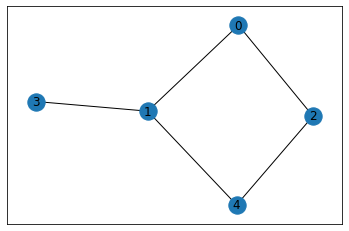

In [3]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [10]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [12]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

For each layer, we apply a gate $RX(\theta)$ and a term $e^{-i\beta H_c} = e^{-i\beta \sum\limits_{i,j\in E} \sigma_i \cdot \sigma_j} = ∏\limits_{i,j\in E} e^{-i\beta \sigma_i \cdot \sigma_j}$.

Applying this term is equivalent to  $e^{-i\beta Z.Z}$ to each edge $(i$ and $j)$, i.e. applying $U_{ZZ}(2\beta)$ to each edge.

### Question 3

In [5]:
def one_qaoa_layer(n_qubits, edges, theta, beta):

    layer = QRoutine()

    for i in range(n_qubits):
      layer.apply(RX(theta), i)
    for i, j in edges:
      layer.apply(U_ZZ(2*beta), i, j)
    

    
    return layer

### Question 4

In [6]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # implement initialization+parameterized circuit
    
    for q in qubits:
      prog.apply(H, q)

    for k in range(n_layers):
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*k], parameters[2*k+1]), qubits)

    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
        b = [2*int(i)-1 for i in sample.state.bitstring]
        # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        for i, j in edges:
          obs+=b[i]*b[j]*sample.probability

    # END TODO
    return obs
    
        

In [7]:
import numpy as np
np.random.random(3)

array([0.70781678, 0.98421616, 0.16805339])

In [8]:
from scipy.optimize import minimize


### Random initialisation

### Question 5: 
réponse à la question:

0.47421157427528515
-0.29375105559275516 -0.6196002603337093 -0.9404531867063434 -0.9840363817402452 -1.3875580348310539 -2.1217091128187127 -2.3057532210811544 -2.6138950119951443 -2.7266614734492194 -2.8728805554681283 -3.0880837042758533 -3.2386669123915595 -3.5074673913757035 -3.7821204453614063 -3.893457909286647 -4.041265160023537 -4.181326665110724 -4.308421245344212 -4.361254890931371 -4.4579939527460235 -4.6129480136047025 -4.703087092300509 -4.731268993478282 -4.741895149575197 -4.746550572006812 -4.751169445116643 -4.75529430741517 -4.759654841607682 -4.763972378994053 -4.766910214598459 -4.769534691151704 -4.771526878773642 -4.773354681734425 -4.7742018525176375 -4.775577954691104 -4.777903681165523 -4.781500502718773 -4.78446707389606 -4.785093043520627 -4.786100355316095 -4.7877812665491675 -4.790161174471559 -4.792205698017064 -4.795131513557196 -4.798265762916643 -4.801989198741782 -4.805391110070516 -4.806575894874193 -4.807510038652452 -4.808257777368061 -4.8090117779

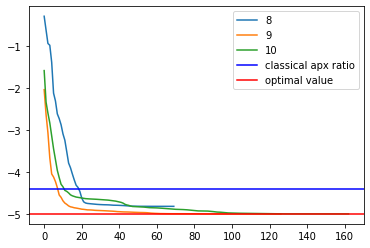

In [15]:
import matplotlib.pylab as plt


for nlayers in range(8,11,1):
    num_params = 2*nlayers
    print(evaluate_parameters(nqubits, edges, np.random.random(num_params), nlayers))
    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       np.random.random(num_params),
                       callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()

### Question 6: smart initialization

In [ ]:
T = 1.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []

    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()